In [19]:
import pandas as pd
import statistics as sts
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Calculate the standard and relative standard deviation
# of LC (liquid chromatography) peak area data

In [4]:
df1 = pd.read_csv('data/SD_RSD.csv')
df1

,Data
0,2957398
1,3733127
2,2900811
3,3010190
4,2810196
5,2084063
6,2812196
7,2830106
8,2710116
9,2910196


In [5]:
#Standard deviation of the data set using the statistics module
sd1 = sts.stdev(df1['Data'])
sd1

398088.9166369884

In [6]:
#Now using the describe pandas function, I select the number from the returned dataframe
summ_df1 = df1.describe()
sd2 = df1.describe().loc['std'][0]
sd2

398088.9166369884

In [7]:
summ_df1

,Data
count,1.000000e+01
mean,2.875840e+06
std,3.980889e+05
min,2.084063e+06
25%,2.810696e+06
50%,2.865458e+06
75%,2.945598e+06
max,3.733127e+06


In [8]:
#But what is the magnitude of the spread compared to the raw data?
#Let's calculate the RSD (relative standard deviation)
the_mean = summ_df1.loc['mean'][0]
the_RSD = round(sd1/the_mean * 100,1)
print(f'{the_RSD}%')

13.8%


In [9]:
#13.8%, not very precise and not great for an LC method.  We probably need to do a bit more optimization or try and figure out the source of the variability.

In [10]:
#Now let's calculate some 95% confidence intervals using scipy.stats
#https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
#See the interval() method for the t continuous variable at:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html#scipy.stats.t
the_data = df1['Data']
interval = st.t.interval(0.95, len(the_data)-1, loc=np.mean(the_data), scale=st.sem(the_data))
interval


(2591064.2443005526, 3160615.555699447)

In [11]:
#What does this tell us?  95% of repeated confidence intervals will include the population mean.  Or, we have 95% confidence the true mean is within the limits above.

In [12]:
#Now, what if we have a rather large RSD, 14%, but we want to be confident that our sample is closely approximating our real mean (the population mean).
#Put a different way, we want to decrease our relative error of the mean to ~5%.
#Then we'll need to increase our n.  But by how much?
#Let's write a function to help us

In [13]:
#First, give ourselves a starting point with an n=10
#Compute the t statistic for 9 degrees of freedom (n=10) at 0.05
the_t = st.t.ppf(1-0.025, 9)
#Calculate our relative error with this t statistic
starting_error = the_t*the_RSD / 10**(0.5)
starting_error

9.871925302145497

In [14]:
#Our starting error is about 10%
#The function below loops until our threshold is met
def findN(N,err,RSD):
    while err > 5:
        deg_free = N - 1
        t_stat = st.t.ppf(1-0.025, deg_free)
        err = t_stat*RSD / N**(0.5)
        N += 1
        print(f'Error:{round(err,1)}% -- N:{N}')
   

In [15]:
findN(10,starting_error,the_RSD)

Error:9.9% -- N:11
Error:9.3% -- N:12
Error:8.8% -- N:13
Error:8.3% -- N:14
Error:8.0% -- N:15
Error:7.6% -- N:16
Error:7.4% -- N:17
Error:7.1% -- N:18
Error:6.9% -- N:19
Error:6.7% -- N:20
Error:6.5% -- N:21
Error:6.3% -- N:22
Error:6.1% -- N:23
Error:6.0% -- N:24
Error:5.8% -- N:25
Error:5.7% -- N:26
Error:5.6% -- N:27
Error:5.5% -- N:28
Error:5.4% -- N:29
Error:5.2% -- N:30
Error:5.2% -- N:31
Error:5.1% -- N:32
Error:5.0% -- N:33


In [16]:
#Voila, at an N = 33, our relative error of the mean is ~5% with 95% confidence
#If you performed N = 33 measurements over and over, 95% of them would have a relative error less than or equal to 5%

# Outliers
#### Outliers in an analytical laboratory can happen for many reasons.  These include: 
* Bench technique (analyst technique) when manipulating samples
* Instrument performance (or lack thereof)
* Materials/reagents quality
* The environment (lack of stable temperature, for instance)
* The sample.  Sometimes it just really is high or low.

#### Below, we'll use some methods to find outliers in a data set of protein concentration readings.

In [17]:
pc_df = pd.read_csv('data/Prot_Conc.csv')
pc_df

,Protein Conc
0,4.59
1,10.00
2,6.07
3,4.73
4,8.91
5,4.48
6,16.65
7,5.17
8,4.59
9,6.38


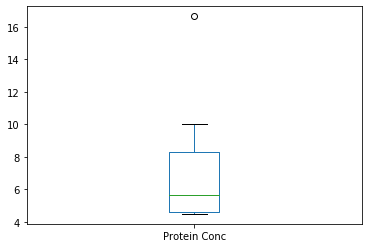

In [22]:
#The human eye/brain tag-team is great at detecting visual anomalies.  So let's see if we have a candidate.
pc_df.plot.box()

In [33]:
#Well lookie there.  I'm thinking it's our data point at 16.65.  Let's see if we can confirm this with an outlier test.
outlier = pc_df.iloc[6]
outlier

Protein Conc    16.65
Name: 6, dtype: float64

In [25]:
#Get a quick count of our data
N = pc_df.count()

#### First, a Grubb's test. 

In [26]:
#Calculating our G-critical value (we could just look it up...)
#Breaking it up into three pieces so the code isn't as ugly
G_crit_a = (N - 1) / N**0.5
G_crit_b = (st.t.ppf(1-(0.025/N), N - 2))**2
G_crit_c = N - 2 + G_crit_b
G_crit = G_crit_a * (G_crit_b / G_crit_c)**0.5
G_crit
#A standard table (see below) yields 2.290 for a data set of N = 10, so looks like we're ok

Protein Conc    2.289954
dtype: float64

In [27]:
#Or, just scrape a web page with Pandas to get the values.
table = pd.read_html('https://chem.libretexts.org/Ancillary_Materials/Reference/Reference_Tables/Analytic_References/Appendix_07%3A_Critical_Values_for_Grubb%E2%80%99s_Test')
print(table[0])

    α⇒   0.05   0.01
    n⇓   0.05   0.01
0    3  1.155  1.155
1    4  1.481  1.496
2    5  1.715  1.764
3    6  1.887  1.973
4    7  2.202  2.139
5    8  2.126  2.274
6    9  2.215  2.387
7   10  2.290  2.482
8   11  2.355  2.564
9   12  2.412  2.636
10  13  2.462  2.699
11  14  2.507  2.755
12  15  2.549  2.755


In [28]:
#Now let's calculate a limit based on our G-critical value
summ_stats = pc_df.describe()
summ_stats

,Protein Conc
count,10.000000
mean,7.157000
std,3.847681
min,4.480000
25%,4.625000
50%,5.620000
75%,8.277500
max,16.650000


In [31]:
#Let's calculate our Limit using the G-critical value, the std deviation, and the mean
the_mean = summ_stats.loc['mean']
the_SD = summ_stats.loc['std']
limit = the_SD * G_crit + the_mean
limit

Protein Conc    15.968012
dtype: float64

In [34]:
#So it is confirmed, our suspected outlier is greater than our limit
outlier > limit

Protein Conc    True
dtype: bool